# BERT training

In this notebook we will explore training BERT on Kaggle's toxic comments dataset. We will then try to extract the learned representation for each comment.

In [1]:
import os
import time

from multiprocessing import Pool

os.chdir('../')

import torch
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm.notebook as tnb
import matplotlib.pyplot as plt

from scipy.stats import describe
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import confusion_matrix, classification_report
from transformers import BertForSequenceClassification, BertTokenizer, AdamW, get_linear_schedule_with_warmup

## Constants

In [2]:
model_id = 'bert-base-uncased'
toxic_train_path = '/media/gio/storage/data/kaggle_toxic/train.csv'
toxic_testdata_path = '/media/gio/storage/data/kaggle_toxic/test.csv'
toxic_testlabs_path = '/media/gio/storage/data/kaggle_toxic/test_labels.csv'

seed = 42
n_cores = 8

## Setup

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Available device: ', device)

# Make everything reproducible
torch.manual_seed(seed)
np.random.seed(seed)

# GPU deterministic mode
if device == 'cuda':
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Available device:  cuda


## Data

In [ ]:
toxic_df_raw = pd.read_csv(toxic_train_path)
toxic_df_testdata = pd.read_csv(toxic_testdata_path)
toxic_df_testlabs = pd.read_csv(toxic_testlabs_path)

In [ ]:
toxic_df_raw.head()

## Preprocessing

### Binarization

The original problem in this dataset is a multi-label classification one. To make things simpler, here we will reduce it to a classic binary problem, toxic vs non-toxic.

In [ ]:
cols_to_keep = ['id', 'comment_text', 'toxic']
toxic_df = toxic_df_raw[cols_to_keep]

In [ ]:
toxic_df

In [ ]:
print(
    'Total number of comments: {}\n'
    'Number of toxic comments: {}\n'
    'Number of non toxic comments: {}\n'.format(
        len(toxic_df),
        len(toxic_df[toxic_df['toxic'] == 1]),
        len(toxic_df[toxic_df['toxic'] == 0])
    )
)

### Merge test set

The original test set contains labels only for a subset of the samples. We will reduce the test set to only the labeled samples. Unlabeled samples will have `-1` as label for every category.

In [ ]:
print(len(toxic_df_testdata))
print(toxic_df_testdata.head())
print(len(toxic_df_testlabs))
print(toxic_df_testlabs.head())

In [ ]:
toxic_df_test = toxic_df_testdata.merge(toxic_df_testlabs)[cols_to_keep]
toxic_df_test = toxic_df_test[toxic_df_test['toxic'] != -1]
print(len(toxic_df_test))
toxic_df_test.head()
toxic_df_test.describe()

### Tokenization and statistics

We are particularly interested in getting a rough estimate of the average number of words/tokens in a comment. This will impact the training batch size.

In [ ]:
def set_bert_separator(par):
    """ Set BERT special separator token.
    """
    
    par[-1] = '[SEP]'

    
def preproc_bert(tokenizer, tokenized_texts_orig, max_len):
    """ Cut to max length, add special tokens, generate attention mask.
    """
    
    # Cut paragraphs to max_len and set the last elements to BERT separator
    tokenized_texts = [['[CLS]',] + ts[: max_len-1] for ts in tokenized_texts_orig]
    _ = [set_bert_separator(ts) for ts in tokenized_texts]

    # Tokens must be converted to BERT's vocabulary indices before passing them to the model
    x_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]  

    # Pad up to max_len with 0s
    x_ids = [np.append(np.array(t), np.zeros(max_len, dtype=np.int32))[:max_len] for t in x_ids]

    # Compute attention mask for each vector
    attn_mask = [[float(i>0) for i in t] for t in x_ids]
    
    return (x_ids, attn_mask)


def worker_tokenizer(tokenizer, df, max_len):
    """ Tokenization worker
    """
    
    tokenized = []
    
    for text in df['comment_text']:
        t = tokenizer.tokenize(text)
        tokenized.append(t)
    
    df['tokenized_text'] = tokenized
    
    # If `max_len` != 0 preprocess for BERT
    if max_len:
        x_ids, attn_mask = preproc_bert(tokenizer, tokenized, max_len)
        df['text_ids'] = x_ids
        df['mask'] = attn_mask
        
    return df
    

def parallel_tokenizer(model_id, df, n_workers=4, max_len=0):
    """ Parallelize tokenizer execution
    """
    
    # Build inputs
    splitdf = np.array_split(df, n_workers)
    tokenizers = [BertTokenizer.from_pretrained(model_id) for i in range(n_workers)]
    max_lens = [max_len for i in range(n_workers)]
    inputs = list(zip(tokenizers, splitdf, max_lens))
    
    pool = Pool(processes=n_workers)
    results = [pool.apply(worker_tokenizer, args=inputs[i]) for i in range(n_workers)]
    
    return pd.concat(results)

In [ ]:
start_time = time.time()

toxic_df_tk = parallel_tokenizer(
    model_id=model_id,
    df=toxic_df,
    n_workers=n_cores
)

print('Tokenization took {:.2f} seconds'.format(time.time() - start_time))

In [ ]:
start_time = time.time()

toxic_df_test_tk = parallel_tokenizer(
    model_id=model_id,
    df=toxic_df_test,
    n_workers=n_cores
)

print('Tokenization took {:.2f} seconds'.format(time.time() - start_time))

In [48]:
tokenparlens = [len(t) for t in toxic_df_tk['tokenized_text']]

print(describe(tokenparlens))
print("Q2 quantile of arr : ", np.quantile(tokenparlens, .50)) 
print("Q1 quantile of arr : ", np.quantile(tokenparlens, .25)) 
print("Q3 quantile of arr : ", np.quantile(tokenparlens, .95))

print('Number of comments under 256 tokens: {}'.format(
    len(np.argwhere(np.array(tokenparlens) < 256))
))

DescribeResult(nobs=159571, minmax=(2, 4948), mean=92.89186004975842, variance=20004.92719143334, skewness=5.3553429545847715, kurtosis=58.19834006471804)
Q2 quantile of arr :  50.0
Q1 quantile of arr :  24.0
Q3 quantile of arr :  308.5
Number of comments under 256 tokens: 148579


#### Tokenization and preprocessing

Given the preceding analysis, the batch size and maximum length of input vectors are as follows.

In [ ]:
max_len = 256
batch_size = 8

In [ ]:
start_time = time.time()

toxic_df_tk = parallel_tokenizer(
    model_id=model_id,
    df=toxic_df,
    n_workers=n_cores,
    max_len=max_len
)

print('Tokenization took {:.2f} seconds'.format(time.time() - start_time))
start_time = time.time()

toxic_df_test_tk = parallel_tokenizer(
    model_id=model_id,
    df=toxic_df_test,
    n_workers=n_cores,
    max_len=max_len
)

print('Tokenization took {:.2f} seconds'.format(time.time() - start_time))

In [ ]:
toxic_df_tk

In [ ]:
toxic_df_test_tk

### Create dataset objects

In [37]:
def get_data_loaders(train_df, test_df, batch_size):
    """ Create torch data loaders.  
    """
    
    cols = ['text_ids', 'toxic', 'mask']
    
    train_x, train_y, train_att = [toxic_df_tk[i].tolist() for i in cols]
    test_x, test_y, test_att = [toxic_df_test_tk[i].tolist() for i in cols]
    
    print('Data shapes:\n'
        'ids_train: {}\n'
        'att_train: {}\n'
        'y_train: {}\n'
        'ids_test: {}\n'
        'att_test: {}\n'
        'y_test: {}'.format(
            len(train_x),
            len(train_att),
            len(train_y),
            len(test_x),
            len(test_att),
            len(test_y)
        )
    )
    
    train_inputs = torch.tensor(train_x)
    train_masks = torch.tensor(train_att)
    train_labels = torch.tensor(train_y)

    validation_inputs = torch.tensor(test_x)
    validation_masks = torch.tensor(test_att)
    validation_labels = torch.tensor(test_y)
      
    train_data = TensorDataset(train_inputs, train_masks, train_labels)
    train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

    validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
    validation_dataloader = DataLoader(validation_data, shuffle=False, batch_size=batch_size)
    
    return train_data, train_dataloader, validation_data, validation_dataloader


In [38]:
train_data, train_dataloader, test_data, test_dataloader = get_data_loaders(
    train_df=toxic_df_tk,
    test_df=toxic_df_test_tk,
    batch_size=batch_size
)

Data shapes:
ids_train: 159571
att_train: 159571
y_train: 159571
ids_test: 63978
att_test: 63978
y_test: 63978


In [40]:
len(test_dataloader) * 8


63984

## BERT

In [45]:
# Support functions

def eval_classification(y_pred, y_true):
    """ Evaluate binary classifier.   
    """
    
    cr = classification_report(y_true, y_pred, digits=6, output_dict=True)
    cm = confusion_matrix(y_true, y_pred)
    
    print(classification_report(y_true, y_pred, digits=6))
    print(confusion_matrix(y_true, y_pred))
    
    return cm, cr


def visualize_losses(losses):
    """ Plot training loss.
    """
    
    plt.figure(figsize=(12,6))
    plt.title("Training loss")
    plt.xlabel("Batch")
    plt.ylabel("Loss")
    plt.plot(losses)
    plt.show()

    
def visualize_accuracies(accuracies):
    """ Plot training accuracies.
    """
    
    plt.figure(figsize=(12,6))
    plt.title("Training accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(accuracies)
    plt.show()
    

def flat_accuracy(preds, labels):
    """ Compute accuracy score.
    """
    
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [43]:
def predict_bert(model, validation_dataloader):
    """ Produce prediction vector.
    """
    
    model.eval()
    prediction = []

    with torch.no_grad():
        for i, batch in enumerate(tnb.tqdm(validation_dataloader)):
            batch = tuple(t.to(device) for t in batch)
            # Unpack the inputs from our dataloader
            b_input_ids, b_input_mask, b_labels = batch
            # Forward pass
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            prediction += torch.argmax(outputs[0],dim=1).tolist()
    
    return prediction

### Parameters

In [ ]:
lr = 1e-5

epochs = 4
total_steps = len(train_dataloader) * epochs

### Training loop

In [ ]:
def train_bert(model_id, device, train_dataloader, lr, num_total_steps, epochs):
    """ Fine tune an instance of BERT.  
    """
    
    model = BertForSequenceClassification.from_pretrained(
        model_id,
        output_hidden_states=True,
        output_attentions=True,
        num_labels=2
    )
    model.to(device)
    
    # Optimizer initialization
    optimizer = AdamW(
        model.parameters(), 
        lr=lr
    )

    # 0 warmup steps is default in Glue example for Huggingface Transformers
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=num_total_steps
    )

    train_losses = []
    train_accuracies = []

    for epoch in tnb.tqdm(range(epochs)):
        model.train()
        e_loss = 0.0
        e_steps = 0.0

        # Train the data for one epoch
        for i, batch in enumerate(tnb.tqdm(train_dataloader)):
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            # Required by pytorch
            optimizer.zero_grad()
            
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs[0]
            train_losses.append(loss.item())
            loss.backward()
            
            optimizer.step()
            scheduler.step()
            
            # Tracking losses
            e_loss += loss.item()
            e_steps += 1

        print("Train loss at epoch {}: {}".format(epoch, e_loss/e_steps))

        # Compute train accuracy at epoch's end
        model.eval()
        e_acc = 0
        e_steps = 0

        # Evaluate data for one epoch
        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)
            b_input_ids, b_input_mask, b_labels = batch
            
            with torch.no_grad():
                # Forward pass, calculate logit predictions
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

            # Move logits and labels to CPU
            logits = outputs[0].detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            e_acc += flat_accuracy(logits, label_ids)
            e_steps += 1

        print("Training accuracy at epoch {}: {}".format(epoch, e_acc/e_steps))
        train_accuracies.append(e_acc/e_steps)

    
    return model, optimizer, train_losses, train_accuracies

In [ ]:
model, optimizer, train_lossses, train_accuracies = train_bert(
    model_id=model_id,
    device=device,
    train_dataloader=train_dataloader,
    lr=lr,
    num_total_steps=total_steps,
    epochs=epochs
)

In [ ]:
torch.save(model.state_dict(), 'model.ckpt')

### Results

#### Training

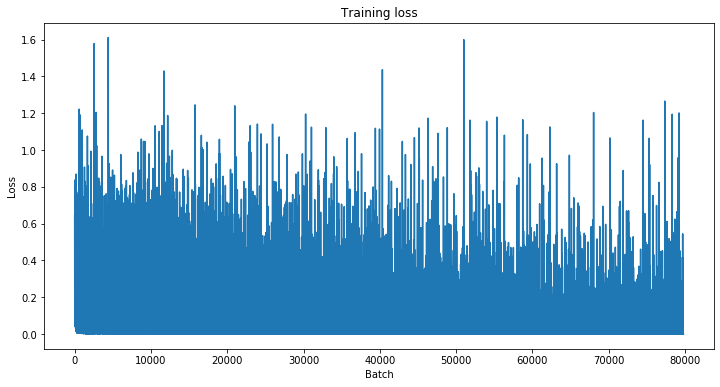

In [31]:
visualize_losses(train_lossses)

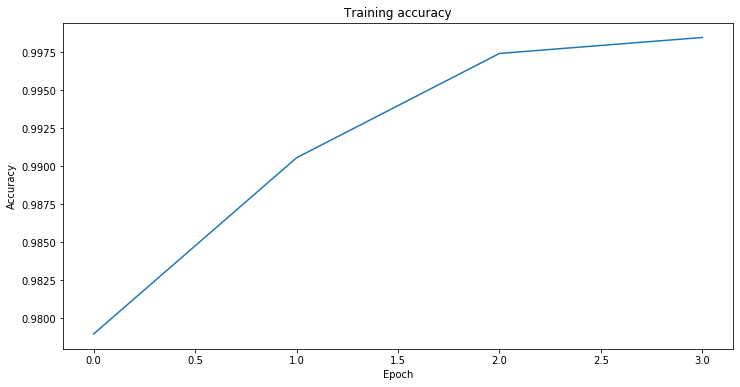

In [46]:
visualize_accuracies(train_accuracies)

#### Testing

In [44]:
prediction = predict_bert(model, test_dataloader)

In [34]:
y_test = toxic_df_test_tk['toxic'].to_numpy()
print(y_test.shape)

(63978,)


In [47]:
cm, cr = eval_classification(prediction, y_test)

              precision    recall  f1-score   support

           0   0.983489  0.926064  0.953913     57888
           1   0.548046  0.852217  0.667095      6090

    accuracy                       0.919035     63978
   macro avg   0.765768  0.889140  0.810504     63978
weighted avg   0.942039  0.919035  0.926611     63978

[[53608  4280]
 [  900  5190]]


## Learned representation

Now we are interested in extracting the learned representation of the input vectors. 

In [57]:
# We first create a dataloader with fixed order for the training set
train_dataloader_ordered = DataLoader(train_data, shuffle=False, batch_size=batch_size)

In [72]:
model.num_parameters

<bound method ModuleUtilsMixin.num_parameters of BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              

In [ ]:
# Then we extract the representation for each batch
train_representations = []

with torch.no_grad():
    for i, batch in enumerate(tnb.tqdm(train_dataloader_ordered), 0):

        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
        loss, logits, hidden_states, attentions = outputs

        # Bert is 12 layers deep, the 13th layer is the classifier.
        representation = hidden_states[11].cpu().numpy()
        
        train_representations.append(representation)